In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']

# Seasons to process
seasons = ['all','DJF','JJA']

# Time slices (future) to process
time_slices = ([#['1991','2020'],
                #['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])

In [3]:
# Read data locations
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [4]:
# Subset to monthly precipitation (let's just look at one run per model for now)
df_mon_pr = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'pr')
                 & (df.member_id == "r1i1p1f1"))])

In [5]:
# Get names of all the models in the subset
pr_source_ids = []
for name, group in df_mon_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        pr_source_ids.append(name)

In [6]:
# Subset to monthly tas (let's just look at one run per model for now)
df_mon_tas = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'tas')
                 & (df.member_id == "r1i1p1f1"))])

In [7]:
# Get names of all the models in the subset
tas_source_ids = []
for name, group in df_mon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        tas_source_ids.append(name)

In [8]:
tas_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [9]:
pr_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [10]:
source_ids=list(set(tas_source_ids).intersection(pr_source_ids))

In [12]:
# Function to load precipitation data
def load_tas_data(source_id, expt_id):
    """
    Load tas data for given source and expt ids
    """
    uri = df_mon_tas[(df_mon_tas.source_id == source_id) &
                         (df_mon_tas.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [13]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all'):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
    # Area weighting
    latr = np.deg2rad(data_tmp['hist'].lat)
    # Use the cosine of the converted latitudes as weights for the average
    weights = np.cos(latr)

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_histG = np.average(mu_hist.mean("lon"),weights=weights.values)
    mu_futrG = np.average(mu_futr.mean("lon"),weights=weights.values)
    dtasG = mu_futrG-mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Out 
    outp = xr.Dataset(
        data_vars = {#'tas_hist': tas_hist,
                     #'tas_futr': tas_futr,
                     #'dmu':     dmu,
                     'dtasG':    ([],dtasG)}

        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [14]:

tdata = {}
tresults = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_tas_data(mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp = load_tas_data(mod_name, experiment_ids[1])
        
        tdata[mod_name] = {}
        tresults[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            tresults[mod_name]["t"+time_slice[0]] = {}
           # Calculate means, sds,...
            tresults[mod_name]['t'+time_slice[0]] = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]])
            print(' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting MIROC6

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time slice 2071-2100
 processed!
2071-2100 processed!
MIROC6 processed!


Starting CESM2

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time 

In [16]:
pd.DataFrame(tresults)

,MIROC6,CESM2,BCC-ESM1,MRI-ESM2-0,CanESM5,CAMS-CSM1-0,GFDL-ESM4,IPSL-CM6A-LR,CESM2-WACCM,BCC-CSM2-MR
t2011,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2021,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2031,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2041,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2051,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2061,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2071,[dtasG],[dtasG],NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]


In [21]:
tresults_new=tresults
for model in tresults:
    for timeperiod in tresults[model]:
        tresults_new[model][timeperiod]=tresults_new[model][timeperiod].dtasG.values.item(0)


In [22]:
tresults_new

{'MIROC6': {'t2011': 0.6976035808199867,
  't2021': 0.9241407659164906,
  't2031': 1.235913284872879,
  't2041': 1.5333446750318558,
  't2051': 1.861462285562311,
  't2061': 2.1434135099715945,
  't2071': 2.475390628014395},
 'CESM2': {'t2011': 1.094390598544635,
  't2021': 1.3375937706218792,
  't2031': 1.6569418225626578,
  't2041': 2.02734796511902,
  't2051': 2.4850242851507574,
  't2061': 3.025131541509893,
  't2071': 3.5409950092355302},
 'BCC-ESM1': {'t2011': 1.0801761490631065, 't2021': 1.2820887939342356},
 'MRI-ESM2-0': {'t2011': 1.0239186884169271,
  't2021': 1.2678370524898241,
  't2031': 1.6142750920263325,
  't2041': 1.9804371803610934,
  't2051': 2.343858082587701,
  't2061': 2.6897764310137973,
  't2071': 3.0422235839063774},
 'CanESM5': {'t2011': 1.4386232260013685,
  't2021': 1.8637849650586986,
  't2031': 2.394865857677871,
  't2041': 2.996470370599411,
  't2051': 3.5794180205155612,
  't2061': 4.184961774420344,
  't2071': 4.787036799847726},
 'CAMS-CSM1-0': {'t2011

In [23]:
pd.DataFrame(tresults_new).to_csv('tresults.csv')

In [11]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

,MIROC6,CESM2,BCC-ESM1,MRI-ESM2-0,CanESM5,CAMS-CSM1-0,GFDL-ESM4,IPSL-CM6A-LR,CESM2-WACCM,BCC-CSM2-MR
t2011,0.697604,1.094391,1.080176,1.023919,1.438623,0.585576,0.812851,1.021362,1.007804,0.964405
t2021,0.924141,1.337594,1.282089,1.267837,1.863785,0.772982,1.021594,1.346130,1.271294,1.241890
t2031,1.235913,1.656942,NaN,1.614275,2.394866,0.993943,1.295160,1.789764,1.642219,1.599642
t2041,1.533345,2.027348,NaN,1.980437,2.996470,1.272332,1.631039,2.248596,2.098605,1.969405
t2051,1.861462,2.485024,NaN,2.343858,3.579418,1.531312,2.001841,2.722717,2.548464,2.325534
t2061,2.143414,3.025132,NaN,2.689776,4.184962,1.834118,2.398149,3.222443,3.027118,2.711012
t2071,2.475391,3.540995,NaN,3.042224,4.787037,2.101574,2.761664,3.826447,3.494716,3.085562


In [25]:
tresults_dict=tresults_new.to_dict()

In [54]:
dt=np.zeros((len(time_slices),len(tresults_dict)))*np.nan 

In [59]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults_dict[model]:
        dt[timecount,modelcount]=tresults_dict[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [60]:
dt

array([[0.69760358, 1.0943906 , 1.08017615, 1.02391869, 1.43862323,
        0.58557645, 0.81285141, 1.0213623 , 1.0078036 , 0.96440512],
       [0.92414077, 1.33759377, 1.28208879, 1.26783705, 1.86378497,
        0.77298177, 1.02159433, 1.34613037, 1.27129431, 1.24188957],
       [1.23591328, 1.65694182,        nan, 1.61427509, 2.39486586,
        0.99394305, 1.29515999, 1.7897644 , 1.64221874, 1.59964209],
       [1.53334468, 2.02734797,        nan, 1.98043718, 2.99647037,
        1.27233195, 1.63103912, 2.24859619, 2.09860518, 1.96940471],
       [1.86146229, 2.48502429,        nan, 2.34385808, 3.57941802,
        1.53131223, 2.00184055, 2.72271729, 2.5484642 , 2.32553355],
       [2.14341351, 3.02513154,        nan, 2.68977643, 4.18496177,
        1.83411814, 2.39814894, 3.22244263, 3.02711843, 2.71101181],
       [2.47539063, 3.54099501,        nan, 3.04222358, 4.7870368 ,
        2.10157417, 2.7616643 , 3.82644653, 3.49471618, 3.08556153]])

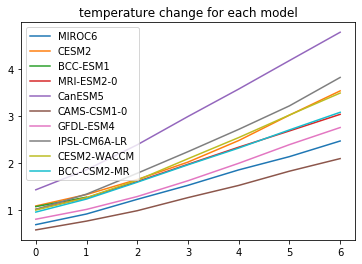

In [61]:
plt.plot(dt)
plt.title('temperature change for each model')
plt.legend(modelnames)

In [62]:
# Function to load precipitation data
def load_pr_data(source_id, expt_id):
    """
    Load precip data for given source and expt ids
    """
    uri = df_mon_pr[(df_mon_pr.source_id == source_id) &
                         (df_mon_pr.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [63]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all'):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
    # Area weighting
    latr = np.deg2rad(data_tmp['hist'].lat)
    # Use the cosine of the converted latitudes as weights for the average
    weights = np.cos(latr)

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_histG = np.average(mu_hist.mean("lon"),weights=weights.values)
    mu_futrG = np.average(mu_futr.mean("lon"),weights=weights.values)
    dmuG = mu_futrG/mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time"))
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time"))
    var_hist = sd_hist ** 2
    var_histG = np.average(var_hist.mean("lon").pr,weights=weights.values)
    sd_histG = np.sqrt(var_histG)
    var_futr = sd_futr ** 2
    var_futrG = np.average(var_futr.mean("lon").pr,weights=weights.values)
    sd_futrG = np.sqrt(var_futrG)
    dsd = sd_futr/sd_hist
    dsdG = sd_futrG/sd_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'mu_hist': mu_hist,
                     'mu_futr': mu_futr,
                     #'dmu':     dmu,
                     'dmuG':    ([],dmuG),
                     'sd_hist': sd_hist.pr,
                     'sd_futr': sd_futr.pr,
                     #'dsd':     dsd.pr,
                     'dsdG':    ([],dsdG)},
        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [64]:

data = {}
results = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_pr_data(mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp = load_pr_data(mod_name, experiment_ids[1])
        
        data[mod_name] = {}
        results[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            results[mod_name]["t"+time_slice[0]] = {}
            for seas in seasons:
                # Calculate means, sds,...
                results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc(data[mod_name]['t'+time_slice[0]],seas)
                print(seas+' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting GFDL-ESM4

Begin processing time slice 2011-2040
all processed!
DJF processed!
JJA processed!
2011-2040 processed!
Begin processing time slice 2021-2050
all processed!
DJF processed!
JJA processed!
2021-2050 processed!
Begin processing time slice 2031-2060
all processed!
DJF processed!
JJA processed!
2031-2060 processed!
Begin processing time slice 2041-2070
all processed!
DJF processed!
JJA processed!
2041-2070 processed!
Begin processing time slice 2051-2080
all processed!
DJF processed!
JJA processed!
2051-2080 processed!
Begin processing time slice 2061-2090
all processed!
DJF processed!
JJA processed!
2061-2090 processed!
Begin processing time slice 2071-2100
all processed!
DJF processed!
JJA processed!
2071-2100 processed!
GFDL-ESM4 processed!


Starting MRI-ESM2-0

Begin processing time slice 2011-2040
all processed!
DJF processed!
JJA processed!
2011-2040 processed!
Begin processing time slice 2021-2050
all processed!
DJF processed!
JJA processed!
2021-2050 processed

In [72]:
#results

In [75]:
# this is rather brute force, sorry
# dmuG, dsdG - also for different seasons 
dsdG_djf=results.copy()
dsdG_jja=results.copy()
dmuG_djf=results.copy()
dmuG_jja=results.copy()
for model in results:
    for timeperiod in results[model]:
        dsdG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dsdG.values.item(0)
        dsdG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dsdG.values.item(0)
        dmuG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dmuG.values.item(0)
        dmuG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dmuG.values.item(0)
        


TypeError: 'float' object is not subscriptable

In [76]:
pd.DataFrame(dsdG_djf)

,GFDL-ESM4,MRI-ESM2-0,IPSL-CM6A-LR,CAMS-CSM1-0,CESM2,BCC-ESM1,CESM2-WACCM,MIROC6,BCC-CSM2-MR,CanESM5
t2011,1.030939,0.958772,1.069258,1.013537,1.066046,1.018551,1.039816,1.004109,1.038669,1.079521
t2021,1.034678,0.983005,1.065308,1.025562,1.082278,1.032016,1.060674,1.006428,1.057812,1.108786
t2031,1.057237,1.008734,1.087724,1.045689,1.105388,NaN,1.109779,0.993048,1.070512,1.127889
t2041,1.090690,1.094888,1.111745,1.043397,1.121343,NaN,1.121593,1.029917,1.073504,1.151836
t2051,1.102006,1.142753,1.158009,1.049514,1.147366,NaN,1.145935,1.034896,1.082534,1.170737
t2061,1.095531,1.158891,1.194014,1.042049,1.186820,NaN,1.157643,1.038537,1.092499,1.208484
t2071,1.099062,1.161113,1.237169,1.059414,1.213157,NaN,1.191385,1.048010,1.105286,1.239221


In [77]:
pd.DataFrame(dsdG_djf).to_csv('dsdG_djf.csv')

In [78]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new

,GFDL-ESM4,MRI-ESM2-0,IPSL-CM6A-LR,CAMS-CSM1-0,CESM2,BCC-ESM1,CESM2-WACCM,MIROC6,BCC-CSM2-MR,CanESM5
t2011,1.030939,0.958772,1.069258,1.013537,1.066046,1.018551,1.039816,1.004109,1.038669,1.079521
t2021,1.034678,0.983005,1.065308,1.025562,1.082278,1.032016,1.060674,1.006428,1.057812,1.108786
t2031,1.057237,1.008734,1.087724,1.045689,1.105388,NaN,1.109779,0.993048,1.070512,1.127889
t2041,1.090690,1.094888,1.111745,1.043397,1.121343,NaN,1.121593,1.029917,1.073504,1.151836
t2051,1.102006,1.142753,1.158009,1.049514,1.147366,NaN,1.145935,1.034896,1.082534,1.170737
t2061,1.095531,1.158891,1.194014,1.042049,1.186820,NaN,1.157643,1.038537,1.092499,1.208484
t2071,1.099062,1.161113,1.237169,1.059414,1.213157,NaN,1.191385,1.048010,1.105286,1.239221


In [81]:
dsdG_djf=dsdG_djf_new.to_dict()

In [82]:
dsdG_djf_np=np.zeros((len(time_slices),len(dsdG_djf)))*np.nan 

In [85]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in dsdG_djf[model]:
        dsdG_djf_np[timecount,modelcount]=dsdG_djf[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [86]:
dsdG_djf_np

array([[1.00410916, 1.06604557, 1.01855125, 0.95877213, 1.07952093,
        1.01353749, 1.03093888, 1.06925774, 1.03981607, 1.03866912],
       [1.00642759, 1.08227811, 1.03201613, 0.98300485, 1.10878608,
        1.02556207, 1.03467764, 1.06530845, 1.06067416, 1.05781245],
       [0.99304771, 1.10538793,        nan, 1.00873414, 1.12788947,
        1.04568893, 1.05723719, 1.08772409, 1.10977942, 1.07051213],
       [1.02991738, 1.12134327,        nan, 1.09488765, 1.1518364 ,
        1.04339748, 1.09069014, 1.11174488, 1.12159305, 1.07350369],
       [1.03489617, 1.14736634,        nan, 1.14275303, 1.17073651,
        1.04951387, 1.10200599, 1.15800893, 1.14593539, 1.08253419],
       [1.03853684, 1.18681991,        nan, 1.1588908 , 1.20848359,
        1.04204886, 1.09553058, 1.19401383, 1.15764291, 1.09249925],
       [1.04800955, 1.21315694,        nan, 1.16111286, 1.23922087,
        1.05941389, 1.09906174, 1.23716927, 1.19138465, 1.10528649]])

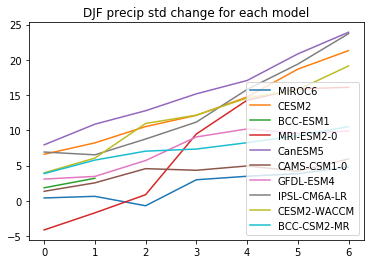

In [90]:
plt.plot((dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)

Text(0, 0.5, 'Precip change (%)')

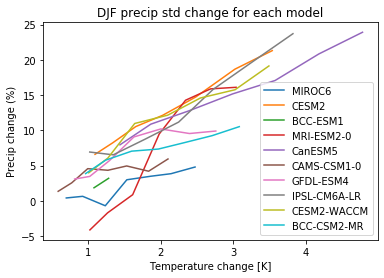

In [94]:
plt.plot(dt,(dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)
plt.xlabel('Temperature change [K]')
plt.ylabel('Precip change (%)')


# Needed: get rid of models with NaNs before taking the multi-model mean

In [104]:
for i in range(10):
    print(modelnames[i])
    print(dt[:,i])
    print(dsdG_djf_np[:,i])
    print

MIROC6
[0.69760358 0.92414077 1.23591328 1.53334468 1.86146229 2.14341351
 2.47539063]
[1.00410916 1.00642759 0.99304771 1.02991738 1.03489617 1.03853684
 1.04800955]
CESM2
[1.0943906  1.33759377 1.65694182 2.02734797 2.48502429 3.02513154
 3.54099501]
[1.06604557 1.08227811 1.10538793 1.12134327 1.14736634 1.18681991
 1.21315694]
BCC-ESM1
[1.08017615 1.28208879        nan        nan        nan        nan
        nan]
[1.01855125 1.03201613        nan        nan        nan        nan
        nan]
MRI-ESM2-0
[1.02391869 1.26783705 1.61427509 1.98043718 2.34385808 2.68977643
 3.04222358]
[0.95877213 0.98300485 1.00873414 1.09488765 1.14275303 1.1588908
 1.16111286]
CanESM5
[1.43862323 1.86378497 2.39486586 2.99647037 3.57941802 4.18496177
 4.7870368 ]
[1.07952093 1.10878608 1.12788947 1.1518364  1.17073651 1.20848359
 1.23922087]
CAMS-CSM1-0
[0.58557645 0.77298177 0.99394305 1.27233195 1.53131223 1.83411814
 2.10157417]
[1.01353749 1.02556207 1.04568893 1.04339748 1.04951387 1.04204886
 

In [107]:
np.nanmean(dt,axis=1)

array([0.97267111, 1.23293357, 1.5803027 , 1.97306415, 2.37773672,
       2.80401369, 3.23506764])

In [111]:
np.nanmean((dsdG_djf_np-1)*100,axis=1)

array([ 3.19218341,  4.56547535,  6.73334441,  9.3212659 , 11.4861159 ,
       13.0496287 , 15.04240273])

Text(0, 0.5, 'Precip change (%)')

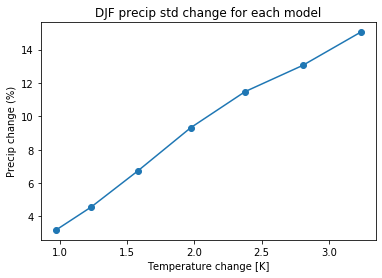

In [113]:
plt.plot(np.nanmean(dt,axis=1),np.nanmean((dsdG_djf_np-1)*100,axis=1),marker='o')
plt.title('DJF precip std change for each model')
plt.xlabel('Temperature change [K]')
plt.ylabel('Precip change (%)')